In [2]:
import scanpy as sc

from os.path import join
import pandas as pd
import anndata
import os
import scanpy as sc
import umap
umap.__version__
import pynndescent
pynndescent.__version__

from os.path import exists
import scipy
import gc
from scipy import sparse
import numpy as np
from joblib import parallel_backend
import time
import numpy as np


In [26]:
basedir = '/mnt/znas/icb_zstore01/groups/ml01/workspace/ignacio.ibarra/theislab/retinal_scRNAseq_integration/data/integration_march_2021/output/retinal_all_all_batch_donor_dataset_cell.type'
ad_path = join(basedir, 'integration/unscaled/HVG.1K/scvi.h5ad')

In [27]:
os.path.exists(ad_path)

True

In [7]:
ad = sc.read_h5ad(ad_path)

In [8]:
ad.shape

(2159366, 1000)

In [28]:
embed_path = join(basedir, 'embeddings/unscaled/HVG.1K/scvi_embed.csv')
os.path.exists(embed_path)

In [23]:
n_sample = int(1e5)
embed = pd.read_csv(embed_path, nrows=n_sample)
ad_embed = anndata.AnnData(obs=embed.head(n_sample) if n_sample is not None else embed)
sc.set_figure_params(facecolor='white')
ad_embed.obsm['X_umap'] = ad_embed.obs[['UMAP1', 'UMAP2']].to_numpy()
# query_name = basename(d).split('_')[2]
# n_cells = "+".join(map(str, ad.obs['batch_donor_dataset'].str.split('_').str[0].value_counts().values))



# title = ",".join([s[:3] for s in embed_filename.replace('scvi_2000000_25_', '').replace('_embed.csv', '').split('_')])
sc.pl.embedding(ad_embed, 'X_umap', color='cell.type') #  show=ei + 1 == grp.shape[0],
               # legend_loc=None, frameon=False, title=title)

### Generate an embedding using a sample of the full data

In [31]:
def reduce_data(adata, batch_key=None, subset=False,
                filter=True, flavor='cell_ranger', n_top_genes=2000, n_bins=20,
                pca=True, pca_comps=50, overwrite_hvg=True,
                neighbors=True, use_rep='X_pca', 
                umap=True):
    """
    overwrite_hvg:
        if True, ignores any pre-existing 'highly_variable' column in adata.var
        and recomputes it if `n_top_genes` is specified else calls PCA on full features.
        if False, skips HVG computation even if `n_top_genes` is specified and uses
        pre-existing HVG column for PCA
    """
#     if n_top_genes is not None and overwrite_hvg:
#         print("HVG")
        
#         overwrite_hvg = False
        
#         ## quick fix: HVG doesn't work on dense matrix
#         if not sparse.issparse(adata.X):
#             adata.X = sparse.csr_matrix(adata.X)
            
#         if batch_key is not None:
#             hvg_list = hvg_batch(adata, batch_key=batch_key, target_genes=n_top_genes, n_bins=n_bins)
#             adata.var['highly_variable'] = np.in1d(adata.var_names, hvg_list)

#         else:
#             print(f"Calculating {n_top_genes} HVGs for reduce_data.")
#             sc.pp.highly_variable_genes(adata,
#                                         n_top_genes=n_top_genes,
#                                         n_bins=n_bins,
#                                         flavor=flavor)

#         n_hvg = np.sum(adata.var["highly_variable"])
#         print(f'Computed {n_hvg} highly variable genes')
    
    print('setting up HVGs')
    assert n_top_genes == adata.shape[1]
    adata.var["highly_variable"] = True
    n_hvg = np.sum(adata.var["highly_variable"])
        
    print('PCA and/or neighbors')
    if pca:
        print("PCA")
        use_hvgs = not overwrite_hvg and "highly_variable" in adata.var
        sc.tl.pca(adata,
                  n_comps=pca_comps, 
                  use_highly_variable=use_hvgs, 
                  svd_solver='arpack', 
                  return_info=True)
    
    if neighbors:
        n_jobs = 4
        print("Nearest Neigbours")
        sc.settings.n_jobs = n_jobs
        from joblib import parallel_backend
        import time
        start_time = time.time()
        with parallel_backend('threading', n_jobs=n_jobs): sc.pp.neighbors(adata, use_rep=use_rep)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    if umap:
        print("UMAP")
        start_time = time.time()
        sc.tl.umap(adata)
        print("--- %s seconds ---" % (time.time() - start_time))
        
    # print('before return')
    # print(adata)


In [37]:
import random
obs_sample = pd.Series(ad.obs_names).sample(n_sample).values
ad_sample = ad[ad.obs_names.isin(obs_sample),:]

In [52]:
ad.obs.dataset.value_counts()

Chen_a     1338319
Chen_b      254881
Chen_c      192326
Roska       158368
Hackney     121778
Sanes        74980
Wong         10707
Scheetz       4459
Hafler        3548
Name: dataset, dtype: int64

In [41]:
result = 'full'
print('Preparing dataset...')
n_jobs = 10
start_time = time.time()


if result == 'embed':
    reduce_data(ad_sample, n_top_genes=None, neighbors=True,
                use_rep='X_emb', pca=False, umap=False)
elif result == 'full':
    sc.pp.filter_genes(ad_sample, min_cells=1)
    reduce_data(ad_sample, n_top_genes=ad_sample.shape[1], neighbors=True,
                use_rep='X_pca', pca=True, umap=False)

print("--- Neighbors done: %s seconds ---" % (time.time() - start_time))        

Preparing dataset...
setting up HVGs
PCA and/or neighbors
PCA
Nearest Neigbours
--- 58.41297435760498 seconds ---
--- Neighbors done: 85.95651721954346 seconds ---


In [43]:
method = 'scvi'

# print(adata)
# Calculate embedding
start_time = time.time()
sc.settings.n_jobs = n_jobs
if method.startswith('conos'):
    print('Calculating graph embedding...')
    sc.tl.draw_graph(ad_sample, key_added_ext='graph')
    basis = 'draw_graph_graph'
    label = 'Graph'
else:
    print('Calculating UMAP...')
    with parallel_backend('threading', n_jobs=n_jobs):
        sc.tl.umap(ad_sample)
    basis = 'umap'
    label = 'UMAP'


print("--- UMAP done: %s seconds ---" % (time.time() - start_time))

print('done...')
import os
# Save embedding coordinates
print('Saving embedding coordinates...')
label = 'UMAP'
basis = 'umap'
ad_sample.obs[label + '1'] = ad_sample.obsm['X_' + basis][:, 0]
ad_sample.obs[label + '2'] = ad_sample.obsm['X_' + basis][:, 1]

Calculating UMAP...
--- UMAP done: 173.19621634483337 seconds ---
done...
Saving embedding coordinates...


In [44]:
print('done...')

done...


In [47]:
ad_sample.shape

(100000, 1000)

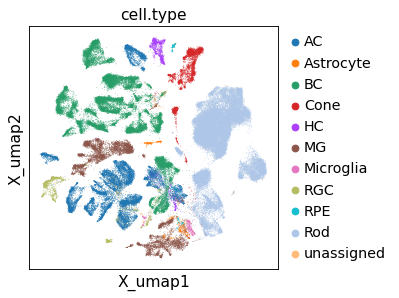

In [46]:
import gc
gc.collect()
sc.set_figure_params(facecolor='white')

coords = ad_sample.obs[['cell.type', 'batch_donor_dataset', label + '1', label + '2' ]]
# coords.to_csv(os.path.join(embed_path), index_label='CellID')
ad_sample.obsm['X_umap'] = ad_sample.obs[['UMAP1', 'UMAP2']].to_numpy()
# query_name = basename(d).split('_')[2]
# n_cells = "+".join(map(str, ad.obs['batch_donor_dataset'].str.split('_').str[0].value_counts().values))

# title = ",".join([s[:3] for s in embed_filename.replace('scvi_2000000_25_', '').replace('_embed.csv', '').split('_')])
sc.pl.embedding(ad_sample, 'X_umap', color='cell.type') #  show=ei + 1 == grp.shape[0],
               # legend_loc=None, frameon=False, title=title)